# **Notebook 3: Fusion Experiments**
In this notebook, we conduct experiments to answer two questions:
1. How should we combine the outputs of each input modality?
2. How should we predict basic emotions and binary sentiment from complex emotion?

Read on for a more detailed explanation of both questions :)


## **Initialization and Data Processing**
We load a JSON of the sentence-by-sentence Hume predictions on the full MELD dataset. See the previous workbooks for how that JSON is generated and cleaned up.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [126]:
sns.set_theme(palette='flare')

In [91]:
def load_json_to_df(directory):
    '''
    converts JSON output to a PD dataframe
    each JSON contains the predicted emotions for one sentence
    '''
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                content = json.load(file)
                metadata = content['metadata']

                # sentiment data
                face_emotions = lowercase_keys(content['predicted']['face'])
                prosody_emotions = lowercase_keys(content['predicted']['prosody'])
                lang_emotions = lowercase_keys(content['predicted']['lang'])

                data.append({
                    'dialogue_id': metadata['dialogue_id'],
                    'time_start': metadata['time_start'],
                    'time_end': metadata['time_end'],
                    'speaker': metadata['speaker'],
                    'emotion': metadata['emotion'],
                    'sentiment': metadata['sentiment'],
                    # 'text_content': metadata['text_content'],
                    'file_name': metadata['file_name'],
                    'face': face_emotions,
                    'prosody': prosody_emotions,
                    'lang': lang_emotions
                })
                
    return pd.DataFrame(data)

In [6]:
def lowercase_keys(dictionary):
    '''
    changes all (String) keys in a dictionary to be fully lower case
    '''
    return {key.lower(): value for key, value in dictionary.items()}

In [7]:
dataset_directory = './dataset/outputs/merged_all'
df = load_json_to_df(dataset_directory)

In [92]:
def get_emotion_scores(df):
    '''
    adds a column for each Hume/complex emotion, which contains a list of form [face_intensity, prosody_intensity, language_intensity]
    '''
    df_with_emotions = df.copy()
    for emotion in all_emotions:
        df_with_emotions[emotion] = df.apply(lambda row: [
            row['face'].get(emotion, None),
            row['prosody'].get(emotion, None),
            row['lang'].get(emotion, None)
        ], axis=1)
            
    return df_with_emotions

## **Exploring the Data**

### **Exploring the Dataset**
We look at sentence length and frequency of the various labels.

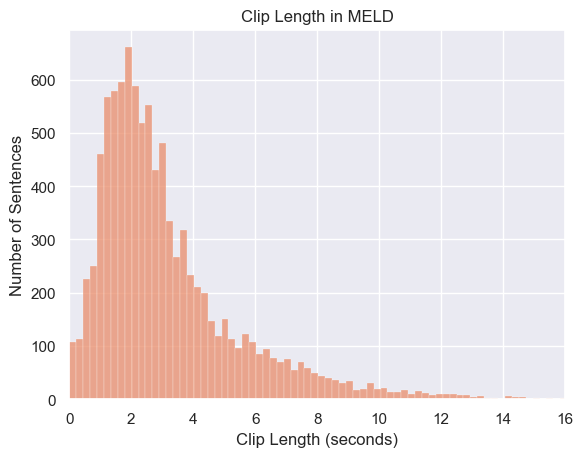

In [208]:
def get_milliseconds(timestamp):
    hours = timestamp[:2]
    minutes = timestamp[3:5]
    seconds = timestamp[6:8]
    milliseconds = timestamp[9:12]
    return float(hours) * 3.6 * (10 ** 6) + float(minutes) * 60000 + float(seconds) * 1000 + float(milliseconds)

explore = df.copy()
explore['length'] = df.apply(lambda row : (get_milliseconds(row['time_end']) - get_milliseconds(row['time_start'])) / 1000, axis=1)
plt.figure('sentence length')
ax = sns.histplot(data=explore, x='length')
ax.set_title('Clip Length in MELD')
ax.set_xlim(0, 16)
ax.set_xlabel('Clip Length (seconds)')
ax.set_ylabel('Number of Sentences')
plt.savefig('./plots/clip_length.png', dpi=400)
plt.show()
plt.close()

In [108]:
explore['length'].describe()

count    9664.000000
mean        3.197436
std         2.438854
min         0.006000
25%         1.625000
50%         2.502000
75%         4.003000
max        41.040000
Name: length, dtype: float64

In [133]:
explore['sentiment'].value_counts()

sentiment
neutral     4531
negative    2875
positive    2258
Name: count, dtype: int64

In [131]:
explore['emotion'].value_counts()

emotion
neutral     4531
joy         1685
surprise    1168
anger       1085
sadness      665
disgust      266
fear         264
Name: count, dtype: int64

### **Exploring the Emotion Data**
Hume has three models that predict emotion based on different modality. One model predicts based on language (the words spoken), another based on prosody (tone of voice, pauses, and vocables), and the last on facial expression. The prosody and face models output 48 emotions. The language model outputs 53 emotions. The five additional emotions output by the language model are {'Annoyance', 'Disapproval', 'Enthusiasm', 'Gratitude', 'Sarcasm'}.

Critically, the MELD dataset contains many sentences labeled with the 7 basic emotions (anger, sadness, fear, joy, surprise, disgust, and neutral). The Hume outputs are _not_ the same as the MELD dataset labels. Going forward, we will refer to the Hume outputs as "complex emotions" and the MELD dataset labels as "basic emotions." As you'll see below, a key part of our work is reducing predictions about "complex emotions" to predictions about "basic emotions."

In [10]:
lang_emotions = set(df['lang'][0].keys())
prosody_emotions = set(df['prosody'][0].keys())
face_emotions = set(df['face'][0].keys())

print("Number of outputted emotions in lang, prosody, and face models:", len(lang_emotions), len(prosody_emotions), len(face_emotions))
print("Emotions outputted by language model but not prosody model:", lang_emotions-prosody_emotions)
print("Emotions outputted by prosody model but not face model:", prosody_emotions-face_emotions)

all_emotions = sorted(list(lang_emotions))
print('All emotions:', all_emotions)

Number of outputted emotions in lang, prosody, and face models: 53 48 48
Emotions outputted by language model but not prosody model: {'gratitude', 'enthusiasm', 'annoyance', 'disapproval', 'sarcasm'}
Emotions outputted by prosody model but not face model: set()
All emotions: ['admiration', 'adoration', 'aesthetic appreciation', 'amusement', 'anger', 'annoyance', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'concentration', 'confusion', 'contemplation', 'contempt', 'contentment', 'craving', 'desire', 'determination', 'disappointment', 'disapproval', 'disgust', 'distress', 'doubt', 'ecstasy', 'embarrassment', 'empathic pain', 'enthusiasm', 'entrancement', 'envy', 'excitement', 'fear', 'gratitude', 'guilt', 'horror', 'interest', 'joy', 'love', 'nostalgia', 'pain', 'pride', 'realization', 'relief', 'romance', 'sadness', 'sarcasm', 'satisfaction', 'shame', 'surprise (negative)', 'surprise (positive)', 'sympathy', 'tiredness', 'triumph']


#### **Emotion Maps**

Below, we create maps from the output of Hume AI (up to 53 emotions) to the seven basic emotions in our dataset. We also map the Hume AI emotions to positive/negative sentiment. Annotations below are manually created. Interesting future exploration could involve mapping each Hume/complex emotion to a weighted sum of the 7 basic emotions, potentially through training an ML model.

In [11]:
BASIC_TO_COMPLEX = {
  'anger': ['anger', 'annoyance', 'disapproval'],
  'fear': ['anxiety', 'doubt', 'fear', 'horror'],
  'joy': ['admiration', 'adoration', 'amusement', 'contentment', 'desire', 'ecstasy', 'enthusiasm', 'entrancement', 'excitement', 'gratitude', 'joy', 'love', 'pride', 'relief', 'romance', 'triumph'],
  'sadness': ['disappointment', 'distress', 'empathic pain', 'guilt', 'nostalgia', 'pain', 'sadness'],
  'surprise': ['awe', 'confusion', 'realization', 'surprise (negative)', 'surprise (positive)'],
  'disgust': ['contempt', 'disgust', 'envy', 'sarcasm'],
  'neutral': ['aesthetic appreciation', 'awkwardness', 'boredom', 'calmness', 'concentration', 'contemplation', 'craving', 'determination', 'embarrassment', 'interest', 'satisfaction', 'shame', 'sympathy', 'tiredness']
}

In [12]:
SENTIMENT_TO_EMOTION = {
    'positive': [
        'admiration', 'adoration', 'aesthetic appreciation', 'amusement', 
        'awe', 'calmness', 'contentment', 'craving', 'desire', 
        'determination', 'ecstasy', 'enthusiasm', 'entrancement', 
        'excitement', 'gratitude', 'interest', 'joy', 'love', 'nostalgia', 
        'pride', 'realization', 'relief', 'romance', 'satisfaction', 
        'surprise (positive)', 'triumph'
    ],
    'negative': [
        'anger', 'annoyance', 'anxiety', 'awkwardness', 'boredom', 
        'confusion', 'contempt', 'disappointment', 'disapproval', 
        'disgust', 'distress', 'doubt', 'embarrassment', 'empathic pain', 
        'envy', 'fear', 'guilt', 'horror', 'pain', 'sadness', 
        'sarcasm', 'shame', 'surprise (negative)', 'tiredness'
    ],
    'neutral': [
        'concentration', 'contemplation', 'sympathy'
    ]
}

## **Methods To Fuse Modalities**
Hume has a facial expression model (predicts based on frame capture of facial expressions in a video), a prosody model (predicts based on signal waveform), and language model (predicts based off words spoken). Each model outputs predictions for up to 53 emotions based on the given input modality. We experiment with two methods to combine the outputs from different modalities to obtain a single number representing the intensity of each emotion.
1. The first method is a simple sum. To get the intensity of an emotion, this function sums the intensity predicated for each modality. In other words: `awe_intensity = face_awe_intensity + prosody_awe_intensity + lang_awe_intensity`
2. The second method is a relative sum. To get the intensity of an emotion, this function takes sums the intensity predicated for each modality, weighted by the predictive accuracy of that modality alone. In other words: `awe_intensity = face_awe_intensity * relative accuracy of face-only prediction + ... (the same for prosody and language)`

### **Method 1: Simple Sum**

In [13]:
def get_simple_sum(df):
    '''
    to get the intensity of an emotion, this function sums the intensity predicated for each modality. In other words:
    awe_intensity = face_awe_intensity + prosody_awe_intensity + lang_awe_intensity
    '''
    simple_sum_df = df.copy()
    for emotion in all_emotions:
        simple_sum_df[emotion] = df[emotion].apply(lambda x: sum([i for i in x if i is not None]))
    return simple_sum_df

### **Method 2: Relative Sum**
We calculate the extent to which each individual modality predicts the final emotion, and use the relative accuracy of each modality to weight the final sum.

#### **2a: Accuracy of Individual Modalities**
First, we test each individual modality to see how predictive it is of the final emotion.

In [14]:
def get_predictions(df, mapping, modality):
    '''
    predicts which basic emotion dominates by taking the mean of all complex emotions corresponding to that basic emotion, and choosing the basic emotion with the highest intensity
    '''
    intensities = pd.DataFrame()
    basic_emotions = sorted(list(mapping.keys()))
    
    for basic_emotion in basic_emotions:
        # this is a disgusting list comprehension that came from flattening a long loop
        complex_emotions = pd.concat([df[modality].apply(lambda row: row.get(complex_emotion, np.nan)).rename(complex_emotion) for complex_emotion in mapping[basic_emotion]], axis=1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            intensities[basic_emotion] = np.nanmean(complex_emotions, axis=1) # column names: basic emotions; each row is a sentence; values are the intensities of the basic emotion for that sentence

    # drop all rows that have all nan values
    intensities = intensities.dropna(how='all')
    
    y_pred = intensities.idxmax(axis=1)
    return y_pred

In [15]:
def get_accuracy(df, target, modality):
    '''
    reports the accuracy of the approach above compared to ground truth
    @param df with a column `y_pred` and a column with the name `target`
    @returns the percent of rows that have identical `y_pred` and `target` values
    ''' 
    if target == 'emotion':
        mapping = BASIC_TO_COMPLEX
    elif target == 'sentiment':
        mapping = SENTIMENT_TO_EMOTION
    else:
        raise Exception('Invalid target')
        
    y_pred = get_predictions(df, mapping, modality)
    comparable_columns = df[target].loc[y_pred.index]
    total_sentences = len(comparable_columns)
    accuracy = np.sum(y_pred == comparable_columns) / total_sentences
    return accuracy

In [16]:
def calc_relative_weights(df, show_results=False, return_results=False):
    # run on all combinations of emotions and modalities
    targets = ['emotion', 'sentiment']
    modalities = ['face','prosody','lang']
    
    results = pd.DataFrame(index=targets, columns=modalities)
    
    for target in targets:
        for modality in modalities:
            accuracy = get_accuracy(df, target, modality)
            results.at[target, modality] = accuracy
    results = results.astype(float)

    # calculate and return relative weights
    relative_weights = results.apply(lambda row: row / np.sum(row), axis=1)

    if show_results:
        print("Accuracy by Modality")
        display(results)
        print("Relative Modality Weights")
        display(relative_weights)
    
    if return_results:
        return relative_weights, results
    return relative_weights

In [17]:
unfused_data = get_emotion_scores(df)
weights, results = calc_relative_weights(unfused_data, show_results=True, return_results=True)

Accuracy by Modality


,face,prosody,lang
emotion,0.220736,0.27680,0.351614
sentiment,0.420151,0.43957,0.509209


Relative Modality Weights


,face,prosody,lang
emotion,0.259949,0.325973,0.414078
sentiment,0.306919,0.321105,0.371976


In [211]:
def display_heatmap(results, title='Accuracy', xlabel='Modalities', ylabel='Targets', savetitle=None, dim=(5, 5), cmap='flare'):

    plt.figure(figsize=dim)
    heatmap = sns.heatmap(results, annot=True, cmap=cmap, cbar=True, fmt=".3f")
    heatmap.axes.set_title(title, weight='bold')
    plt.xlabel(xlabel, weight='bold')
    plt.ylabel(ylabel, weight='bold')
    
    if savetitle:
        output_path = os.path.join('plots', f"snsfull-{savetitle}.png")
        plt.savefig(output_path, dpi=400, bbox_inches='tight')
        
    plt.show()
    plt.close()

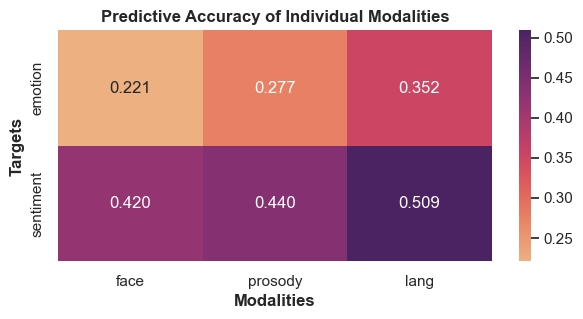

In [212]:
display_heatmap(results, title='Predictive Accuracy of Individual Modalities', savetitle='individual_results', dim=(7,3))

#### **2b: Fusion**
And now let's put those relative weights to use!

In [21]:
def get_relative_weights(df, target):
    '''
    to get the intensity of an emotion, this function takes sums the intensity predicated for each modality, weighted by the predictive accuracy of that modality alone. In other words:
    awe_intensity = face_awe_intensity * relative accuracy of face-only prediction + ... (the same for prosody and language)
    '''
    weights_df = df.copy()
    # df with rows of form [face_weight, prosody_weight, lang_weight]
    weights = calc_relative_weights(df)
    target_weights = list(weights.loc[target])
    for emotion in all_emotions:
        weights_df[emotion] = df[emotion].apply(lambda row: sum([modality * weight for modality, weight in zip(row, target_weights) if modality is not None]))
    return weights_df

#### **Fused Data**
You can see the results below for unfused data, the simple sum, and the relative sum.

In [22]:
unfused_data = get_emotion_scores(df)
unfused_data[all_emotions].head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,"[0.06504425406455994, 0.022758565843105316, 0....","[0.06249423697590828, 0.03556216135621071, 0.0...","[0.04378323256969452, 0.048479046672582626, 0....","[0.10984793305397034, 0.10526715219020844, 0.0...","[0.07023322582244873, 0.009564670734107494, 0....","[None, None, 0.06103894995017485]","[0.23527665436267853, 0.3857785165309906, 0.01...","[0.0604485422372818, 0.11854732036590576, 0.02...","[0.1651034653186798, 0.19066542387008667, 0.04...","[0.3031272292137146, 0.0043082404881715775, 0....",...,"[0.042181357741355896, 0.01836511678993702, 0....","[0.4183056950569153, 0.020628023892641068, 0.0...","[None, None, 0.10864562405781313]","[0.10099265724420547, 0.02373618260025978, 0.0...","[0.15196873247623444, 0.009249993599951267, 0....","[0.04697226360440254, 0.10891266912221909, 0.0...","[0.029800768941640854, 0.2879158854484558, 0.1...","[0.0714893639087677, 0.010579154826700687, 0.0...","[0.3178665339946747, 0.004696393385529518, 0.0...","[0.02455400675535202, 0.01950868032872677, 0.0..."
1,"[0.157891646027565, 0.020334316417574883, 0.00...","[0.18560457229614258, 0.03395294398069382, 0.0...","[0.06629054248332977, 0.020838947966694832, 0....","[0.7867404818534851, 0.5041403770446777, 0.012...","[0.04145737737417221, 0.03573905676603317, 0.0...","[None, None, 0.46579816937446594]","[0.07368505001068115, 0.053568098694086075, 0....","[0.08006695657968521, 0.03468756377696991, 0.0...","[0.17440909147262573, 0.10333520174026489, 0.0...","[0.05464916303753853, 0.022142475470900536, 0....",...,"[0.06405898183584213, 0.022221563383936882, 0....","[0.07285343110561371, 0.0748855471611023, 0.01...","[None, None, 0.05588552728295326]","[0.3786504566669464, 0.0317472480237484, 0.020...","[0.03222194314002991, 0.03189694136381149, 0.0...","[0.033408716320991516, 0.03169639781117439, 0....","[0.047405216842889786, 0.07614438235759735, 0....","[0.06093302741646767, 0.02735159546136856, 0.0...","[0.053562525659799576, 0.03739813715219498, 0....","[0.1469549834728241, 0.018648531287908554, 0.0..."
2,"[0.1355416178703308, 0.0019911935087293386, 0....","[0.14524513483047485, 0.001237751916050911, 0....","[0.08534330874681473, 0.00125335983466357, 0.0...","[0.2627289593219757, 0.03767635300755501, 0.07...","[0.060464538633823395, 0.7850090265274048, 0.0...","[None, None, 0.4267812648957426]","[0.1068153977394104, 0.1929686814546585, 0.003...","[0.12040386348962784, 0.0033133188262581825, 0...","[0.1449272334575653, 0.06497494876384735, 0.02...","[0.2385137975215912, 0.006561266258358955, 0.1...",...,"[0.09234434366226196, 0.0016950550489127636, 0...","[0.15672947466373444, 0.027856314554810524, 0....","[None, None, 0.13992716507478195]","[0.4191046357154846, 0.0014875942142680287, 0....","[0.05593309551477432, 0.03740129992365837, 0.0...","[0.04628724977374077, 0.2547690272331238, 0.04...","[0.05024944618344307, 0.006165230181068182, 0....","[0.04872221499681473, 0.01337588019669056, 0.0...","[0.30524617433547974, 0.01750240847468376, 0.0...","[0.09129779040813446, 0.0010897249449044466, 0..."
3,"[0.19967254996299744, 0.014609414152801037, 0....","[0.2502001225948334, 0.008824382908642292, 0.0...","[0.09184423834085464, 0.01098825316876173, 0.0...","[0.6044479012489319, 0.07877805083990097, 0.01...","[0.02981541119515896, 0.012417307123541832, 0....","[None, None, 0.22206583205196592]","[0.08739206939935684, 0.04069868475198746, 0.0...","[0.08297539502382278, 0.010686038993299007, 0....","[0.21429067850112915, 0.13979117572307587, 0.0...","[0.13431282341480255, 0.0369437076151371, 0.15...",...,"[0.138758584856987, 0.009727532044053078, 0.00...","[0.09321610629558563, 0.09799036383628845, 0.0...","[None, None, 0.0721766793479522]","[0.3680289089679718, 0.046006496995687485, 0.1...","[0.07091721147298813, 0.0704825296998024

In [23]:
simple_sum_df = get_simple_sum(unfused_data)
simple_sum_df[all_emotions].head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.113213,0.110906,0.167296,0.293160,0.083402,0.061039,0.631442,0.200746,0.398527,0.339479,...,0.063478,0.444098,0.108646,0.166622,0.165534,0.231506,0.429508,0.087610,0.326392,0.052859
1,0.181922,0.221711,0.089570,1.303591,0.157794,0.465798,0.174297,0.116273,0.308405,0.175204,...,0.088541,0.159355,0.055886,0.430596,0.068952,0.085206,0.129962,0.117579,0.258729,0.175573
2,0.157448,0.156416,0.096339,0.371670,0.934164,0.426781,0.303047,0.140118,0.235914,0.347603,...,0.100742,0.189885,0.139927,0.438770,0.102839,0.350203,0.080523,0.065453,0.342460,0.106047
3,0.219823,0.260342,0.107373,0.703012,0.062753,0.222066,0.138998,0.095686,0.395364,0.329748,...,0.148754,0.229217,0.072177,0.519280,0.155562,0.127531,0.085248,0.120443,0.187275,0.121971
4,0.214409,0.177453,0.141758,0.596467,0.227856,0.146953,0.304378,0.267599,0.515090,0.302759,...,0.091047,0.262754,0.062211,0.252684,0.157209,0.741672,0.349275,0.080865,0.212933,0.084927


In [24]:
weighted_df = get_relative_weights(unfused_data, 'emotion')
weighted_df[all_emotions]

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.034849,0.033158,0.058254,0.095186,0.022867,0.025275,0.191215,0.063363,0.122775,0.093470,...,0.018165,0.117601,0.044988,0.051337,0.044306,0.079026,0.147890,0.024327,0.085746,0.016385
1,0.049203,0.060207,0.025036,0.374112,0.055800,0.192877,0.056096,0.032749,0.091718,0.062174,...,0.024832,0.048159,0.023141,0.117142,0.020775,0.027340,0.039799,0.036886,0.095584,0.048408
2,0.044129,0.042273,0.026628,0.110087,0.308334,0.176721,0.092020,0.039170,0.069625,0.106595,...,0.027333,0.052016,0.057941,0.116958,0.030667,0.115431,0.025055,0.018415,0.093216,0.029744
3,0.058961,0.068461,0.029337,0.190998,0.020295,0.091952,0.040501,0.025891,0.118367,0.112585,...,0.039352,0.071913,0.029887,0.154245,0.047275,0.046232,0.026667,0.036006,0.056666,0.036801
4,0.065223,0.050904,0.045524,0.173400,0.071766,0.060850,0.091405,0.081937,0.157179,0.082322,...,0.024395,0.071568,0.025760,0.069909,0.046374,0.273222,0.121550,0.022832,0.057247,0.024399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9659,0.018509,0.014066,0.014635,0.072716,0.069334,0.159116,0.155676,0.023103,0.179117,0.089064,...,0.008902,0.148183,0.020174,0.021394,0.089134,0.106656,0.030171,0.077956,0.058378,0.008757
9660,0.019683,0.021956,0.015576,0.063897,0.042261,0.013837,0.140256,0.024890,0.230921,0.079046,...,0.024518,0.105414,0.009653,0.029452,0.075401,0.052630,0.021444,0.027079,0.078534,0.011610
9661,0.052854,0.057189,0.025360,0.144467,0.018993,0.002098,0.067735,0.039639,0.110982,0.099186,...,0.020624,0.123446,0.002181,0.056877,0.057838,0.042093,0.236096,0.036088,0.119242,0.015093
9662,0.028424,0.025262,0.019256,0.092936,0.224625,0.146272,0.128978,0.028646,0.105723,0.091629,...,0.025718,0.119962,0.015976,0.051403,0.065765,0.055396,0.017689,0.034870,0.106132,0.016202


In [25]:
weighted_df = get_relative_weights(unfused_data, 'sentiment')
weighted_df[all_emotions]

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.036723,0.035379,0.056915,0.096547,0.025968,0.022705,0.199950,0.064709,0.127802,0.106338,...,0.019934,0.136931,0.040414,0.054201,0.051218,0.077518,0.143181,0.027400,0.100492,0.017073
1,0.056364,0.068669,0.027945,0.408075,0.054180,0.173266,0.057316,0.036277,0.098116,0.060490,...,0.027637,0.050727,0.020788,0.133922,0.021930,0.027909,0.041385,0.038381,0.090854,0.054800
2,0.049648,0.048671,0.030220,0.119243,0.303618,0.158753,0.095960,0.044119,0.075020,0.113449,...,0.031380,0.059019,0.052050,0.135871,0.032712,0.114295,0.026370,0.020497,0.106638,0.033452
3,0.068036,0.080115,0.033406,0.218172,0.020771,0.082603,0.043948,0.029651,0.126013,0.112041,...,0.045811,0.074214,0.026848,0.166877,0.049666,0.044340,0.027804,0.038560,0.060388,0.039205
4,0.068851,0.055794,0.046678,0.188042,0.073276,0.054663,0.096413,0.086200,0.164569,0.094412,...,0.028146,0.081786,0.023141,0.079099,0.049827,0.258535,0.118656,0.025382,0.066067,0.026859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9659,0.020414,0.015448,0.016207,0.076298,0.071679,0.142938,0.159109,0.026336,0.185902,0.102064,...,0.009643,0.154774,0.018123,0.023601,0.089867,0.103466,0.030221,0.078776,0.064254,0.009534
9660,0.022030,0.023757,0.017261,0.068236,0.047852,0.012430,0.143519,0.028749,0.230967,0.087759,...,0.025484,0.113048,0.008671,0.032867,0.077716,0.055258,0.023302,0.029210,0.087291,0.012788
9661,0.052741,0.057608,0.026311,0.144752,0.021605,0.001885,0.077983,0.041237,0.117768,0.114089,...,0.022517,0.144815,0.001959,0.058745,0.067495,0.043693,0.223686,0.039171,0.139531,0.015236
9662,0.031866,0.028958,0.021833,0.105890,0.221570,0.131400,0.131615,0.032696,0.116815,0.101943,...,0.030041,0.123515,0.014352,0.059377,0.068514,0.056102,0.019581,0.035497,0.107312,0.017919


## **Predicting the Base Emotion**
Now we have an intensity score for each complex emotion. How do we combine the complex emotions to predict the base emotion? We try two approaches.
1. **Group Average:** The first approach maps the complex emotions into label groups (each complex emotion is assigned one basic emotion and one sentiment -- either 'positive' or 'negative'). We average the intensities of all the complex emotions that correspond to a given label in order to get the average intensity of that label. In other words, to get the average 'anger' intensity, we average the intensities of the complex emotions that correspond to anger: 'anger', 'annoyance', and 'disapproval'.
2. **Classifier:** Our second approach is to train a classifier (a small neural network) that learns the relationship between the complex emotions and each label.

#### **Predicting by Group Average**

In [26]:
def pred_highest_intensity(df, target, show=True):

    # get mapping based on prediction target
    if target == 'emotion':
        mapping = BASIC_TO_COMPLEX
    elif target == 'sentiment':
        mapping = SENTIMENT_TO_EMOTION
    else:
        raise Exception('Invalid target')
    
    labels = sorted(list(mapping.keys()))
    intensities = pd.DataFrame()
    individual_emotions = pd.DataFrame()

    for label in labels:
        scores = pd.concat([df[complex_emotion] for complex_emotion in mapping[label]], axis=1)
        individual_emotions = pd.concat([individual_emotions, scores], axis=1)

        # Suppress runtime warnings for mean of empty slice
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            intensities[label] = np.nanmean(scores, axis=1)
        
    if show:
        print('Intensity of Complex Emotions (Summed Across All Modalities)')
        display(individual_emotions.head())
        print('Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)')
        display(intensities.head())
    return intensities.idxmax(axis=1)

In [27]:
pred_simple = pred_highest_intensity(simple_sum_df, 'sentiment')

Intensity of Complex Emotions (Summed Across All Modalities)


,anger,annoyance,anxiety,awkwardness,boredom,confusion,contempt,disappointment,disapproval,disgust,...,joy,love,nostalgia,pride,realization,relief,romance,satisfaction,surprise (positive),triumph
0,0.083402,0.061039,0.631442,0.398527,0.339479,0.761083,0.146461,0.471141,0.046357,0.120238,...,0.163262,0.111888,0.103241,0.056022,0.371698,0.090459,0.063478,0.166622,0.429508,0.052859
1,0.157794,0.465798,0.174297,0.308405,0.175204,0.235026,0.175186,0.151792,0.069740,0.091744,...,0.972664,0.392363,0.089382,0.182604,0.137222,0.181911,0.088541,0.430596,0.129962,0.175573
2,0.934164,0.426781,0.303047,0.235914,0.347603,0.416873,0.699780,0.539362,0.240520,0.459483,...,0.300405,0.257029,0.093593,0.123818,0.267122,0.283896,0.100742,0.438770,0.080523,0.106047
3,0.062753,0.222066,0.138998,0.395364,0.329748,0.201934,0.233197,0.579443,0.153993,0.111278,...,0.589405,0.472978,0.103137,0.134557,0.475667,0.204946,0.148754,0.519280,0.085248,0.121971
4,0.227856,0.146953,0.304378,0.515090,0.302759,0.568479,0.300794,0.547843,0.174505,0.318521,...,0.285123,0.211190,0.078912,0.089104,0.391240,0.097248,0.091047,0.252684,0.349275,0.084927


Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)


,negative,neutral,positive
0,0.278813,0.287984,0.183815
1,0.158618,0.116092,0.276257
2,0.314799,0.169540,0.189593
3,0.179191,0.187735,0.254247
4,0.293063,0.185424,0.194144


In [28]:
pred_weights = pred_highest_intensity(weighted_df, 'sentiment')

Intensity of Complex Emotions (Summed Across All Modalities)


,anger,annoyance,anxiety,awkwardness,boredom,confusion,contempt,disappointment,disapproval,disgust,...,joy,love,nostalgia,pride,realization,relief,romance,satisfaction,surprise (positive),triumph
0,0.025968,0.022705,0.199950,0.127802,0.106338,0.242250,0.046967,0.147438,0.017244,0.037682,...,0.052842,0.034888,0.032733,0.017613,0.124874,0.028473,0.019934,0.054201,0.143181,0.017073
1,0.054180,0.173266,0.057316,0.098116,0.060490,0.077404,0.059121,0.050403,0.025942,0.029280,...,0.300958,0.121032,0.027791,0.056788,0.043850,0.057777,0.027637,0.133922,0.041385,0.054800
2,0.303618,0.158753,0.095960,0.075020,0.113449,0.134290,0.233575,0.175202,0.089468,0.150367,...,0.093018,0.079233,0.028869,0.038679,0.085185,0.087370,0.031380,0.135871,0.026370,0.033452
3,0.020771,0.082603,0.043948,0.126013,0.112041,0.064643,0.078794,0.193600,0.057282,0.036762,...,0.181649,0.145321,0.031994,0.042002,0.158098,0.066631,0.045811,0.166877,0.027804,0.039205
4,0.073276,0.054663,0.096413,0.164569,0.094412,0.191420,0.098919,0.179247,0.064912,0.101579,...,0.088415,0.065138,0.024534,0.027965,0.132854,0.030434,0.028146,0.079099,0.118656,0.026859


Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)


,negative,neutral,positive
0,0.088260,0.091224,0.060087
1,0.053099,0.038149,0.086882
2,0.103012,0.052959,0.059338
3,0.059211,0.060235,0.080469
4,0.095540,0.060192,0.061898


In [29]:
def score(df, target):
    pred = pred_highest_intensity(df, target, show=False)
    return np.nanmean(df[target] == pred)

#### **Prediction by Group Average: Simple Sum vs. Weighted Sum Accuracy Comparison**

In [30]:
simple_emotion = score(simple_sum_df, 'emotion')
simple_sentiment = score(simple_sum_df, 'sentiment')
weighted_emotion = score(weighted_df, 'emotion')
weighted_sentiment = score(weighted_df, 'sentiment')

In [31]:
data = {
    'simple': [simple_emotion, simple_sentiment],
    'weighted': [weighted_emotion, weighted_sentiment]
}
index = ['emotion', 'sentiment']
fusion_results = pd.DataFrame(data, index=index)
fusion_results

,simple,weighted
emotion,0.342405,0.348200
sentiment,0.529905,0.537459


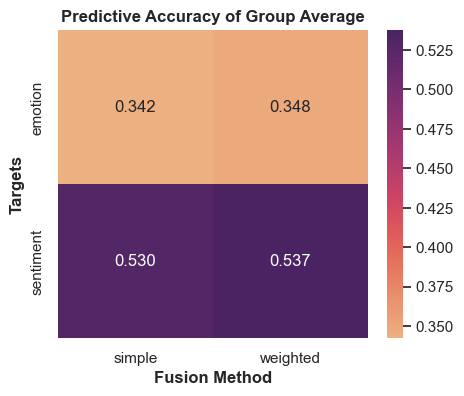

In [215]:
display_heatmap(fusion_results, 'Predictive Accuracy of Group Average', xlabel='Fusion Method', savetitle='group_average', dim=(5, 4))

In [33]:
print('Accuracy at predicting emotion:', round(simple_emotion * 100, 2))
print('Accuracy at predicting sentiment:', round(simple_sentiment * 100, 2))

Accuracy at predicting emotion: 34.24
Accuracy at predicting sentiment: 52.99


In [34]:
print('Accuracy at predicting emotion:', round(weighted_emotion * 100, 2))
print('Accuracy at predicting sentiment:', round(weighted_sentiment * 100, 2))

Accuracy at predicting emotion: 34.82
Accuracy at predicting sentiment: 53.75


**Observations**: Odd that sentiment prediction is identical (a quick look through the data shows that every prediction is the same for all sentences).

#### **Predicting by Classifier**
Let's try training a small neural network that takes in the simple sum complex emotions and predicts the final emotion.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [36]:
inputs = simple_sum_df[all_emotions]
inputs.head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.113213,0.110906,0.167296,0.293160,0.083402,0.061039,0.631442,0.200746,0.398527,0.339479,...,0.063478,0.444098,0.108646,0.166622,0.165534,0.231506,0.429508,0.087610,0.326392,0.052859
1,0.181922,0.221711,0.089570,1.303591,0.157794,0.465798,0.174297,0.116273,0.308405,0.175204,...,0.088541,0.159355,0.055886,0.430596,0.068952,0.085206,0.129962,0.117579,0.258729,0.175573
2,0.157448,0.156416,0.096339,0.371670,0.934164,0.426781,0.303047,0.140118,0.235914,0.347603,...,0.100742,0.189885,0.139927,0.438770,0.102839,0.350203,0.080523,0.065453,0.342460,0.106047
3,0.219823,0.260342,0.107373,0.703012,0.062753,0.222066,0.138998,0.095686,0.395364,0.329748,...,0.148754,0.229217,0.072177,0.519280,0.155562,0.127531,0.085248,0.120443,0.187275,0.121971
4,0.214409,0.177453,0.141758,0.596467,0.227856,0.146953,0.304378,0.267599,0.515090,0.302759,...,0.091047,0.262754,0.062211,0.252684,0.157209,0.741672,0.349275,0.080865,0.212933,0.084927


In [37]:
labels = simple_sum_df[['emotion', 'sentiment']]
labels.head()

,emotion,sentiment
0,joy,positive
1,neutral,neutral
2,anger,negative
3,sadness,negative
4,anger,negative


In [38]:
def train_model(df, target, return_pred=False):
    '''
    @param target is either 'emotion' or 'sentiment'
    '''
    inputs = df[all_emotions]
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels[target], test_size=0.2, random_state=42)
    model = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    display_acc = round(accuracy * 100, 2)
    print(f"Accuracy at predicting {target} is {display_acc}%")
    if return_pred:
        return accuracy, model.predict(X_test)
    return accuracy

In [39]:
simple_emotion = train_model(simple_sum_df, 'emotion')
simple_sentiment = train_model(simple_sum_df, 'sentiment')
weighted_emotion = train_model(weighted_df, 'emotion')
weighted_sentiment = train_model(weighted_df, 'sentiment')

Accuracy at predicting emotion is 57.06%
Accuracy at predicting sentiment is 63.32%
Accuracy at predicting emotion is 58.92%
Accuracy at predicting sentiment is 64.67%


In [40]:
clf_data = {
    'simple': [simple_emotion, simple_sentiment],
    'weighted': [weighted_emotion, weighted_sentiment]
}
clf_results = pd.DataFrame(clf_data, index=index)
clf_results

,simple,weighted
emotion,0.570616,0.589240
sentiment,0.633213,0.646663


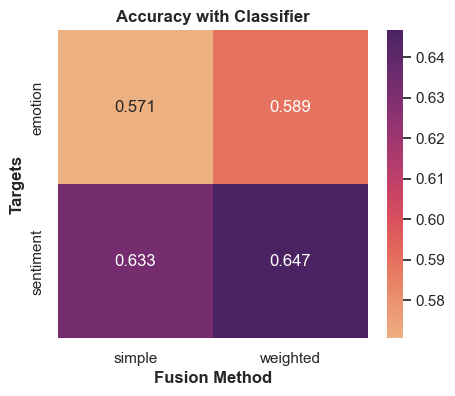

In [213]:
display_heatmap(clf_results, title='Accuracy with Classifier', xlabel='Fusion Method', dim=(5, 4), savetitle='classifier')

**Observations**: The neural network is much better at predicting emotion but less accurate at predicting sentiment (and even worse than random chance). Changing the random state of the train-test split also significantly changes the accuracy, suggesting that the model is probably overfitting and the small sample size of data is skewing results.

## **The Big Bad Classifier**
What if we don't use the simple sum or weighted sum to fuse emotions? Let's train a classifier on the unfused features.

In [163]:
def separate_emotions(df, all_emotions):
    '''
    Adds three columns for each emotion representing the intensity scores from face, prosody, and language modalities.
    '''
    new_data = {}

    for emotion in all_emotions:
        new_data[f'{emotion}_face'] = df.apply(lambda row: row['face'].get(emotion, np.nan), axis=1)
        new_data[f'{emotion}_prosody'] = df.apply(lambda row: row['prosody'].get(emotion, np.nan), axis=1)
        new_data[f'{emotion}_lang'] = df.apply(lambda row: row['lang'].get(emotion, np.nan), axis=1)

    new_columns_df = pd.DataFrame(new_data, index=df.index)

    # replace all null entries with the average of the nonnull modalities
    for emotion in all_emotions:
        emotion_columns = [f'{emotion}_face', f'{emotion}_prosody', f'{emotion}_lang']
        new_columns_df[emotion_columns] = new_columns_df[emotion_columns].apply(
            lambda row: row.fillna(np.nanmean(row)), axis=1
        )

    return new_columns_df

In [164]:
separate_emotions = separate_emotions(df, all_emotions)
unfused = separate_emotions.to_numpy()

In [187]:
def train_no_fusion(inputs, labels, target):
    '''
    @param target is either 'emotion' or 'sentiment'
    '''
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels[target], test_size=0.2, random_state=42)

    # scale the data; fit only to X_train
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # regularize higher than default
    model = MLPClassifier(random_state=42, max_iter=2000, activation='relu', alpha=0.001).fit(X_train_scaled, y_train)
    accuracy = model.score(X_test_scaled, y_test)
    display_acc = round(accuracy * 100, 2)
    print(f"Accuracy at predicting {target} is {display_acc}%")
    return accuracy

In [188]:
labels = df[['emotion', 'sentiment']]

In [189]:
unfused_acc = train_no_fusion(unfused, labels, 'emotion')

Accuracy at predicting emotion is 51.94%


In [190]:
unfused_acc_sentiment = train_no_fusion(unfused, labels, 'sentiment')

Accuracy at predicting sentiment is 57.01%


In [205]:
class_data = {'emotion': unfused_acc, 'sentiment': unfused_acc_sentiment}
class_data_df = pd.DataFrame(class_data, index=['Classifier Only (No Fusion)']).T

## **Evaluations**
We show that our multimodal approach does better than unimodal approaches. Our approach performs about 10 percentage points worse than the SOTA (14.2% worse). We also evaluate the extent to which our predictions are consistent with each other.

In [206]:
results_renamed = results.rename(columns={'face': 'Face Only', 'prosody': 'Prosody Only', 'lang': 'Language Only'})
group_renamed = fusion_results.rename(columns={'simple': 'Simple Sum with Group', 'weighted': 'Weighted Sum with Group'})
clf_renamed = clf_results.rename(columns={'simple': 'Simple Sum with Classifier', 'weighted': 'Weighted Sum with Classifier'})
all_results = pd.concat([results_renamed, group_renamed,class_data_df, clf_renamed], axis=1)
all_results

,Face Only,Prosody Only,Language Only,Simple Sum with Group,Weighted Sum with Group,Classifier Only (No Fusion),Simple Sum with Classifier,Weighted Sum with Classifier
emotion,0.220736,0.27680,0.351614,0.342405,0.348200,0.519400,0.570616,0.589240
sentiment,0.420151,0.43957,0.509209,0.529905,0.537459,0.570098,0.633213,0.646663


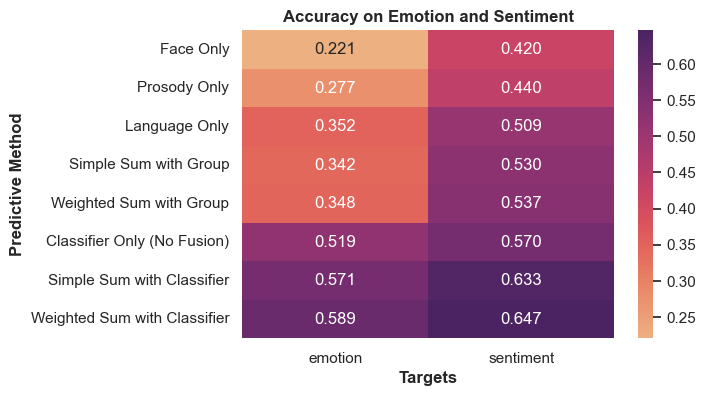

In [214]:
display_heatmap(all_results.T, title='Accuracy on Emotion and Sentiment', xlabel='Targets', ylabel='Predictive Method', dim=(6, 4), savetitle='all')

In [44]:
# we omit surprise, which can be either positive or negative
BASIC_TO_SENTIMENT = {
    'anger': 'negative',
    'sadness': 'negative',
    'neutral': 'neutral',
    'joy': 'positive',
    'disgust': 'negative',
    'fear': 'negative',
}

In [45]:
_, pred_emotion = train_model(simple_sum_df, 'emotion', return_pred=True)
_, pred_sentiment = train_model(simple_sum_df, 'sentiment', return_pred=True)

Accuracy at predicting emotion is 57.06%
Accuracy at predicting sentiment is 63.32%


In [46]:
clf_pred = pd.DataFrame(np.vstack([pred_emotion, pred_sentiment]), index=['emotion', 'sentiment']).T
no_surprise = clf_pred['emotion'] != 'surprise'
clf_no_surprise = clf_pred[no_surprise]

In [47]:
basic_emotions = ['fear', 'disgust', 'sadness', 'anger', 'neutral', 'surprise', 'joy']
emotion_frequencies = [np.sum(clf_pred['emotion'] == emotion) for emotion in basic_emotions]
relative_frequency = [round((freq / np.sum(emotion_frequencies)) * 100, 2) for freq in emotion_frequencies]
freq_data = {
    'emotions': basic_emotions,
    'frequency': emotion_frequencies,
    'relative frequency (%)': relative_frequency
}
freq = pd.DataFrame(freq_data)
freq

,emotions,frequency,relative frequency (%)
0,fear,33,1.71
1,disgust,29,1.50
2,sadness,88,4.55
3,anger,186,9.62
4,neutral,1092,56.49
5,surprise,227,11.74
6,joy,278,14.38


In [48]:
clf_no_surprise['predicted sentiment'] = clf_no_surprise['emotion'].apply(lambda emotion : BASIC_TO_SENTIMENT[emotion])

/var/folders/dp/jng7b5b51rbbqd9mnzyrqxw80000gn/T/ipykernel_6201/3616678805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clf_no_surprise['predicted sentiment'] = clf_no_surprise['emotion'].apply(lambda emotion : BASIC_TO_SENTIMENT[emotion])


In [49]:
np.sum(clf_no_surprise['sentiment'] == clf_no_surprise['predicted sentiment']) / len(clf_no_surprise)

0.8558030480656507

**Observations:** Our classifier never predicts digust!

# **Scratch Work**

## **Selecting Significant Emotions**
We graph the intensity across all the emotions, on all modalities. We can then choose a threshold for when an emotion is 'significant,' and only use 'significant' emotions to predict the final sentiment of the sentence.

In [51]:
mean_intensity = simple_sum_df[all_emotions].mean(axis=None)

In [52]:
THRESHOLD = mean_intensity

In [18]:
# Older matplotlib implementation that still had nice results

# def display_heatmap(results, title='Accuracy', xlabel='Modalities', ylabel='Targets', savetitle=None):
#     indices = results.index.tolist()
#     columns = results.columns.tolist()
    
#     # plot heatmap
#     fig, ax = plt.subplots()
#     heatmap = ax.imshow(results, cmap='viridis', interpolation='nearest')
    
#     ax.set_xticks(np.arange(len(columns)))
#     ax.set_yticks(np.arange(len(indices)))
#     ax.set_xticklabels(columns)
#     ax.set_yticklabels(indices)
#     plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
#     plt.colorbar(heatmap)
    
#     ax.set_title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)

#     if savetitle:
#         output_path = os.path.join('plots', savetitle + '.png')
#         plt.savefig(output_path)
    
#     plt.show()